In [1]:
# =======================================================
# CS-698R, Assignment 1
# 
# Ques 1: 2-Armed Bernoulli Bandit
# 		  10-Armed Gaussian Bandit
# 
# Extensive comparison of different exploration strategies
# ========================================================

# Create Virtual Environment

## Install Python3.8 and Virtualenv
```
sudo apt install python3.8
pip install virtualenv
```

## Create and activate environment
```
virtualenv -p path_to_python3.8 env_name
virtualenv env_name/bin/activate
```

## Install and run Jupyter Notebook
```
pip install jupyter notebook
```

# Install Packages
We first install the packages required for this notebook. Unfortunately because of the way pip and jupyter works 
after running the following commands a restart of the kernel/runtime is necessary.

In [2]:
!pip install -e ../Environments
!pip install matplotlib
!pip install gym

Obtaining file:///data/aish/CS698R/Environments
  Attempting uninstall: environments
    Found existing installation: environments 1.0.0
    Uninstalling environments-1.0.0:
      Successfully uninstalled environments-1.0.0
  Running setup.py develop for environments


# <span style="color:red">Restart the kernel</span>

In [3]:
import os

import numpy as np

import matplotlib.pyplot as plt 
import gym

In [4]:
def decaying_epsilon_greedy(env_class, params, maxEpisodes, init_epsilon, decay_rate, decay_type):
    """
    Parameters:
    ----------
    init_epsilon: initial value of epsilon
    decay_rate  : decaying rate of the epsilon
    decay_type  : linear or exponential
    
    Pure Exploitation Strategy:
    --------------------------
    init_epsilon = 0
    
    Pure Exploration Strategy:
    -------------------------
    init_epsilon = 1 and decay_rate = None

    Epsilon Greedy Strategy:
    -----------------------
    decay_rate = None

    """

    def decay_epsilon(epsilon, decay_rate, decay_type):
        min_value = 0.0
        if decay_type == 'linear':
            epsilon = max(min_value, epsilon-decay_rate*epsilon)
        else:
            epsilon = max(min_value, epsilon*np.exp(-1*decay_rate))
        return epsilon

    n_envs, n_actions = params.shape
    q_est = np.zeros((n_envs, maxEpisodes, n_actions))
    action_taken = np.zeros((n_envs, maxEpisodes, n_actions))

    for env_id in range(n_envs):
        if env_class=="BernoulliBandit":
            env = gym.make("environments:two_armed_bernoulli_bandit-v0", mu=params[env_id])
        else:
            env = gym.make("environments:ten_armed_gaussian_bandit-v0", mean=params[env_id])

        q = np.zeros((n_actions, 1)).squeeze()
        n = np.zeros((n_actions, 1)).squeeze()
        
        epsilon = init_epsilon

        for ep in range(maxEpisodes):
            env.reset()
            start_state = env.state

            u = np.random.uniform()
            if u > epsilon:
                action = np.argmax(q)
            else:
                action = np.random.randint(0, env.action_space.n)
        
            end_state, reward, _, _ = env.step(action)
            n[action] = n[action] + 1
            q[action] = q[action] + (reward - q[action])/float(n[action])
            q_est[env_id][ep] = q
            action_taken[env_id][ep][action] = 1

            if decay_rate is not None:
                epsilon = decay_epsilon(epsilon, decay_rate, decay_type)

            # print('Env: {:02d}, Episode: {:02d}, Epsilon: {:3.2f}, Sampled value: {:3.2f}, Start state: {}, Action: {}, Reached state: {}, Reward: {}'.format(env_id+1, ep+1, epsilon, u, start_state, action, end_state, reward)) 

    return q_est, action_taken

In [5]:
def softmax_stragtegy(env_class, params, maxEpisodes, init_tau, decay_rate, min_temp=0.01):
    """
    Parameters:
    ----------
    init_tau   : initial value of temperature
    decay_rate : decaying rate of the temperature
    min_temp   : minimum value of temperature
    """


    def decay_temperature(tau, decay_rate, min_temp):
        return min(min_temp, tau - tau*decay_rate)
        
    
    n_envs, n_actions = params.shape
    q_est = np.zeros((n_envs, maxEpisodes, n_actions))
    action_taken = np.zeros((n_envs, maxEpisodes, n_actions))

    for env_id in range(n_envs):
        if env_class=="BernoulliBandit":
            env = gym.make("environments:two_armed_bernoulli_bandit-v0", mu=params[env_id])
        else:
            env = gym.make("environments:ten_armed_gaussian_bandit-v0", mean=params[env_id])

        q = np.zeros((n_actions, 1)).squeeze()
        n = np.zeros((n_actions, 1)).squeeze()
        tau = init_tau

        for ep in range(maxEpisodes):
            env.reset()
            start_state = env.state
            
            softmax_prob = np.exp(q/tau)    # tau is the temperature
            softmax_prob = softmax_prob/(np.sum(softmax_prob))
            action = np.random.choice(np.arange(env.action_space.n), p = softmax_prob)
            
            end_state, reward, _, _ = env.step(action)
            n[action] = n[action] + 1
            q[action] = q[action] + (reward - q[action])/float(n[action])
            q_est[env_id][ep] = q
            action_taken[env_id][ep][action] = 1

            if decay_rate is not None:
                tau = decay_temperature(tau, decay_rate, min_temp)
            
            # print('Env: {:02d}, Episode: {:02d}, Temperature: {:3.2f}, Start state: {}, Action: {}, Reached state: {}, Reward: {}'.format(env_id+1, ep+1, tau, start_state, action, end_state, reward)) 

    return q_est, action_taken

In [6]:
def ucb_strategy(env_class, params, maxEpisodes, c):
    """
    Parameters:
    ----------
    c : hyperparameter of Upper Confidence Bound strategy
    """
    n_envs, n_actions = params.shape
    q_est = np.zeros((n_envs, maxEpisodes, n_actions))
    action_taken = np.zeros((n_envs, maxEpisodes, n_actions))

    for env_id in range(n_envs):
        if env_class=="BernoulliBandit":
            env = gym.make("environments:two_armed_bernoulli_bandit-v0", mu=params[env_id])
        else:
            env = gym.make("environments:ten_armed_gaussian_bandit-v0", mean=params[env_id])

        q = np.zeros((n_actions, 1)).squeeze()
        n = np.zeros((n_actions, 1)).squeeze()
        
        for ep in range(maxEpisodes):
            env.reset()
            start_state = env.state

            if ep < env.action_space.n:
                action = ep
            else:
                ucb = c*np.sqrt(np.log(np.exp(1))/n)
                action = np.argmax(q+ucb)
            
            end_state, reward, _, _ = env.step(action)
            n[action] = n[action] + 1
            q[action] = q[action] + (reward - q[action])/float(n[action])
            q_est[env_id][ep] = q
            action_taken[env_id][ep][action] = 1

            # print('Env: {:02d}, Episode: {:02d}, Start state: {}, Action: {}, Reached state: {}, Reward: {}'.format(env_id+1, ep+1, start_state, action, end_state, reward)) 

    return q_est, action_taken

In [7]:
def get_avg_regret(q_val, actions):
    """
    Parameters:
    ----------
    q_val   : np.array of shape(n_envs, maxEpisodes, env.action_space.n)
    actions : np.array of shape(n_envs, maxEpisodes, env.action_space.n)
    """

    n_envs, maxEpisodes, n_actions = q_val.shape
    optimal_val    = np.max(q_val, axis = 2)
    optimal_action = np.argmax(q_val, axis = 2)
    
    actual_val    = np.sum(q_val*actions, axis=2)
    actual_action = np.argmax(actions, axis=2)

    regret = optimal_val - actual_val
    avg_regret = np.sum(regret, axis=0)/n_envs
    
    return avg_regret

In [8]:
def get_avg_reward(q_val, actions):
    """
    Parameters:
    ----------
    q_val   : np.array of shape(n_envs, maxEpisodes, env.action_space.n)
    actions : np.array of shape(n_envs, maxEpisodes, env.action_space.n)
    """

    n_envs, maxEpisodes, n_actions = q_val.shape
    reward     = np.sum(q_val*actions, axis=2)
    avg_reward = np.sum(reward, axis=0)/n_envs

    return avg_reward

In [9]:
def get_optimal_actions(q_val, actions):
    """
    Parameters:
    ----------
    q_val   : np.array of shape(n_envs, maxEpisodes, env.action_space.n)
    actions : np.array of shape(n_envs, maxEpisodes, env.action_space.n)
    """

    n_envs, maxEpisodes, n_actions = q_val.shape
    optimal_action = np.argmax(q_val, axis = 2)
    actual_action  = np.argmax(actions, axis=2)
    
    frac_optimal = np.sum((optimal_action == actual_action), axis=0)/n_envs

    return frac_optimal

In [10]:
def print_header(msg):
    print("\n\n")
    print("="*40)
    print(msg)
    print("="*40)

In [11]:
def print_q_table(q_est):
    print("\n")
    msg = "ep"
    for a in range(q_est.shape[1]):
        msg = "{} | {:6d}".format(msg, a)
    print("-"*len(msg))
    print(msg)
    print("-"*len(msg))

    for ep, q in enumerate(q_est):
        msg = "{:2d}".format(ep+1)
        for v in q:
            msg = "{} | {:5.4f}".format(msg, v)
        print(msg)
    print("-"*len(msg))

In [12]:
def explore_exploit(env_class, n_actions, n_envs=50, maxEpisodes=1000, sample_int=1, figsize=(20,15)):
	"""
	Parameters:
	-----------
	env_class   : BernoulliBandit or GaussianBandit
	n_actions   : number of bandits
	n_envs      : number of different environments to be considered
	max_episodes: number of timesteps for each environment
	sample_int  : to reduce episodes for plotting
	"""

	if env_class=="BernoulliBandit":
		mu_all = np.random.uniform(size = [n_envs, n_actions])
		suffix = "bernoulli"
	else:
		mu_all = np.random.normal(size=[n_envs, n_actions])
		suffix = "gaussian"

	# comparison of exploration vs exploitation for different epsilons
	# ----------------------------------------------------------------
	epsilons   = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1]

	figs = plt.figure(12, figsize=figsize)

	legend = []
	for eps in epsilons:
		q_all, action_all = decaying_epsilon_greedy(env_class, mu_all, maxEpisodes, eps, None, None)
	
		avg_regret = get_avg_regret(q_all, action_all)
		avg_reward = get_avg_reward(q_all, action_all)
		frac_opt   = get_optimal_actions(q_all, action_all)

		plt.figure(0)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

		plt.figure(1)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])
		
		plt.figure(2)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

		legend.append("epsilon = {:3.2f}".format(eps))

	plt.figure(0)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Reward")
	plt.title("Epsilon Greedy Strategy")
    
	plt.figure(1)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Regret")
	plt.title("Epsilon Greedy Strategy")
    
	plt.figure(2)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Optimal Actions")
	plt.title("Epsilon Greedy Strategy")
    
    
	# hypertuning the decay rate for epsilon greedy strategy with initial fixed epsilon=0.2
	# -------------------------------------------------------------------------------------
	eps = 0.2
	decay_rate = [0.01, 0.05, 0.1, 0.3, 0.5]

# 	figs = plt.figure(3, figsize=figsize)

	legend = []
	for dr in decay_rate:
		q_all, action_all = decaying_epsilon_greedy(env_class, mu_all, maxEpisodes, eps, dr, "linear")
	
		avg_regret = get_avg_regret(q_all, action_all)
		avg_reward = get_avg_reward(q_all, action_all)
		frac_opt   = get_optimal_actions(q_all, action_all)

		plt.figure(3)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

		plt.figure(4)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])
		
		plt.figure(5)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

		legend.append("epsilon = {:3.2f}_linear_decay_{:3.2f}".format(eps, dr))
	
	plt.figure(3)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Reward")
	plt.title("Decaying Epsilon Greedy Strategy for Epsilon=0.2")

	plt.figure(4)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Regret")
	plt.title("Decaying Epsilon Greedy Strategy for Epsilon=0.2")
    
	plt.figure(5)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Optimal Actions")
	plt.title("Decaying Epsilon Greedy Strategy for Epsilon=0.2")

    
	# hypertuning the temperature for softmax strategy
	# -------------------------------------------------------------------------------------
	temps = [0.1, 1, 10, 100, 1000]
	
# 	figs = plt.figure(3, figsize=figsize)

	legend = []
	for tau in temps:
		q_all, action_all = softmax_stragtegy(env_class, mu_all, maxEpisodes, tau, None)
	
		avg_regret = get_avg_regret(q_all, action_all)
		avg_reward = get_avg_reward(q_all, action_all)
		frac_opt   = get_optimal_actions(q_all, action_all)

		plt.figure(6)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

		plt.figure(7)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])
		
		plt.figure(8)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

		legend.append("temperature = {:4.3f}".format(tau))
	
	plt.figure(6)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Reward")
	plt.title("Different Temperatures for Softmax Strategy")
    
	plt.figure(7)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Regret")
	plt.title("Different Temperatures for Softmax Strategy")
    
	plt.figure(8)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Optimal Actions")
	plt.title("Different Temperatures for Softmax Strategy")
    
    
	# hypertuning the c value of UCB strategy
	# -------------------------------------------------------------------------------------
	c_vals = [0.01, 0.1, 0.5, 1, 2, 5]
	
# 	figs = plt.figure(3, figsize=figsize)

	legend = []
	for c in c_vals:
		q_all, action_all = ucb_strategy(env_class, mu_all, maxEpisodes, c)
	
		avg_regret = get_avg_regret(q_all, action_all)
		avg_reward = get_avg_reward(q_all, action_all)
		frac_opt   = get_optimal_actions(q_all, action_all)

		plt.figure(9)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

		plt.figure(10)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])
		
		plt.figure(11)
		plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

		legend.append("c = {:4.3f}".format(c))
	
	plt.figure(9)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Reward")
	plt.title("Different c-values for UCB Strategy")
    
	plt.figure(10)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Regret")
	plt.title("Different c-values for UCB Strategy")
    
	plt.figure(11)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Optimal Actions")
	plt.title("Different c-values for UCB Strategy")

In [13]:
def all_strategies(env_class, n_actions, eps, eps_decay, decay_rate, temp, c, n_envs=50, maxEpisodes=1000, sample_int=1, figsize=(20,15)):
	"""
	Parameters:
	-----------
	env_class   : BernoulliBandit or GaussianBandit
	n_actions   : number of bandits
	n_envs      : number of different environments to be considered
	max_episodes: number of timesteps for each environment
	sample_int  : to reduce episodes for plotting
	"""

	if env_class=="BernoulliBandit":
		mu_all = np.random.uniform(size = [n_envs, n_actions])
		suffix = "bernoulli"
	else:
		mu_all = np.random.normal(size=[n_envs, n_actions])
		suffix = "gaussian"

	# comparison of different strategies
	# ----------------------------------------------------------------
    
	figs = plt.figure(3, figsize=figsize)
	legend = []

	# Exploitation
	# ------------    
	q_all, action_all = decaying_epsilon_greedy(env_class, mu_all, maxEpisodes, 0, None, None)
	
	avg_regret = get_avg_regret(q_all, action_all)
	avg_reward = get_avg_reward(q_all, action_all)
	frac_opt   = get_optimal_actions(q_all, action_all)

	plt.figure(0)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

	plt.figure(1)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])

	plt.figure(2)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

	legend.append("Pure exploitation strategy")
    
	# Exploitation
	# ------------    
	q_all, action_all = decaying_epsilon_greedy(env_class, mu_all, maxEpisodes, 1, None, None)
	
	avg_regret = get_avg_regret(q_all, action_all)
	avg_reward = get_avg_reward(q_all, action_all)
	frac_opt   = get_optimal_actions(q_all, action_all)

	plt.figure(0)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

	plt.figure(1)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])

	plt.figure(2)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

	legend.append("Pure exploration strategy")
    
	# Epsilon greedy strategy
	# -----------------------
	q_all, action_all = decaying_epsilon_greedy(env_class, mu_all, maxEpisodes, eps, None, None)
	
	avg_regret = get_avg_regret(q_all, action_all)
	avg_reward = get_avg_reward(q_all, action_all)
	frac_opt   = get_optimal_actions(q_all, action_all)

	plt.figure(0)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

	plt.figure(1)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])

	plt.figure(2)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

	legend.append("epsilon = {:3.2f} greedy strategy".format(eps))
    
    
	# Epsilon decay strategy
	# -----------------------
	q_all, action_all = decaying_epsilon_greedy(env_class, mu_all, maxEpisodes, eps_decay, decay_rate, "linear")
	
	avg_regret = get_avg_regret(q_all, action_all)
	avg_reward = get_avg_reward(q_all, action_all)
	frac_opt   = get_optimal_actions(q_all, action_all)

	plt.figure(0)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

	plt.figure(1)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])

	plt.figure(2)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

	legend.append("epsilon = {:3.2f}_linear_decay_{:3.2f}".format(eps_decay, decay_rate))

    
	# Softmax strategy
	# ----------------

	q_all, action_all = softmax_stragtegy(env_class, mu_all, maxEpisodes, temp, None)
	
	avg_regret = get_avg_regret(q_all, action_all)
	avg_reward = get_avg_reward(q_all, action_all)
	frac_opt   = get_optimal_actions(q_all, action_all)

	plt.figure(0)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

	plt.figure(1)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])
	
	plt.figure(2)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

	legend.append("Softmax with temp = {:4.3f}".format(temp))
    
    
	# UCB strategy
	# ------------
	q_all, action_all = ucb_strategy(env_class, mu_all, maxEpisodes, c)
	
	avg_regret = get_avg_regret(q_all, action_all)
	avg_reward = get_avg_reward(q_all, action_all)
	frac_opt   = get_optimal_actions(q_all, action_all)

	plt.figure(0)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_reward[0:maxEpisodes:sample_int])

	plt.figure(1)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], avg_regret[0:maxEpisodes:sample_int])

	plt.figure(2)
	plt.plot(np.arange(maxEpisodes)[0:maxEpisodes:sample_int], frac_opt[0:maxEpisodes:sample_int])

	legend.append("UCB with c = {:4.3f}".format(c))

	plt.figure(0)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Reward")
	plt.title("Comparison of Different Strategies")
    
	plt.figure(1)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Regret")
	plt.title("Comparison of Different Strategies")
    
	plt.figure(2)
	plt.legend(legend, loc=1)
	# plt.ylim([0,1.1])
	plt.xlabel("Episodes")
	plt.ylabel("Optimal Actions")
	plt.title("Comparison of Different Strategies")

In [14]:
print_header("Testing implementation of 2-armed Bernoulli Bandit")
test_mu  = [[0, 0], [1, 0], [0, 1], [1, 1], [0.5, 0.5]]
episodes = 20
for mu in test_mu:
    bb_env = gym.make("environments:two_armed_bernoulli_bandit-v0", mu=mu)#BernoulliBandit(mu)
    print("\nalpha: {:3.2f} | beta: {:3.2f}".format(mu[0], mu[1]))

    for ep in range(episodes):
        bb_env.reset()
        start_state = bb_env.state
        action = np.random.randint(0, bb_env.n_bandit)
        end_state, reward, _, _ = bb_env.step(action)
        print('Episode: {:02d}, Start state: {}, Action: {}, Reached state: {}, Reward: {}'.format(ep+1, start_state, action, end_state, reward))




Testing implementation of 2-armed Bernoulli Bandit

alpha: 0.00 | beta: 0.00
Episode: 01, Start state: 0, Action: 0, Reached state: 2, Reward: 0
Episode: 02, Start state: 0, Action: 0, Reached state: 2, Reward: 0
Episode: 03, Start state: 0, Action: 0, Reached state: 2, Reward: 0
Episode: 04, Start state: 0, Action: 1, Reached state: 1, Reward: 0
Episode: 05, Start state: 0, Action: 1, Reached state: 1, Reward: 0
Episode: 06, Start state: 0, Action: 0, Reached state: 2, Reward: 0
Episode: 07, Start state: 0, Action: 1, Reached state: 1, Reward: 0
Episode: 08, Start state: 0, Action: 0, Reached state: 2, Reward: 0
Episode: 09, Start state: 0, Action: 0, Reached state: 2, Reward: 0
Episode: 10, Start state: 0, Action: 0, Reached state: 2, Reward: 0
Episode: 11, Start state: 0, Action: 1, Reached state: 1, Reward: 0
Episode: 12, Start state: 0, Action: 1, Reached state: 1, Reward: 0
Episode: 13, Start state: 0, Action: 0, Reached state: 2, Reward: 0
Episode: 14, Start state: 0, Action:

<Figure size 1440x1080 with 0 Axes>

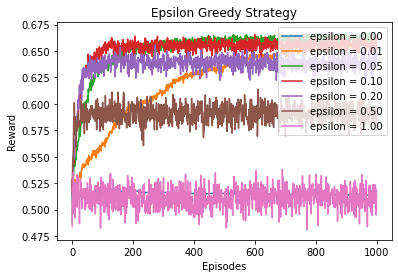

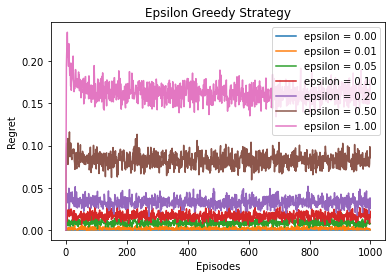

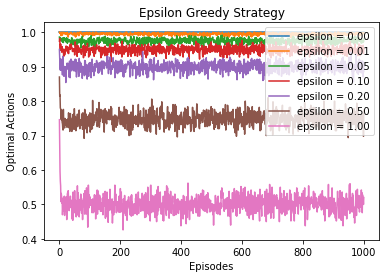

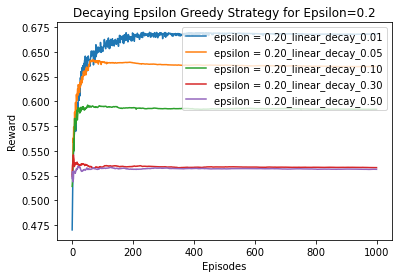

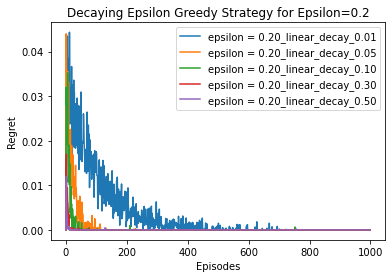

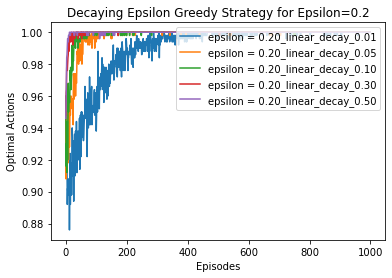

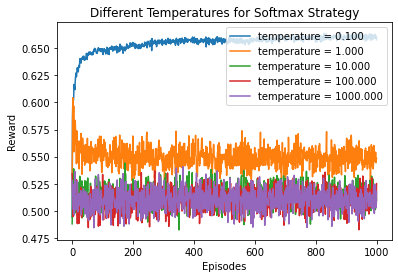

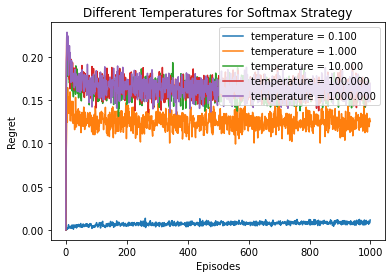

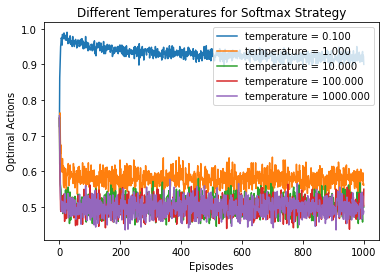

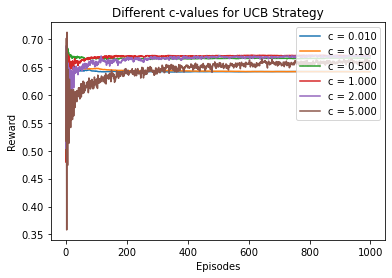

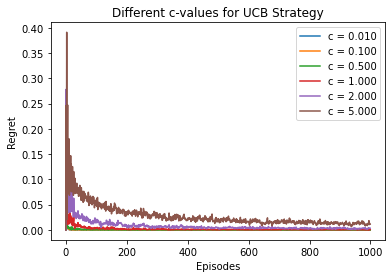

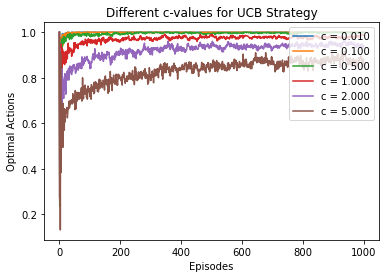

In [15]:
# =======================================================
# 2-Armed Bernoulli Bandit 
# Playing with different hyperparameters for each strategy
# =======================================================

n_envs = 500
maxEpisodes = 1000
explore_exploit("BernoulliBandit", 2, n_envs, maxEpisodes)

<Figure size 1440x1080 with 0 Axes>

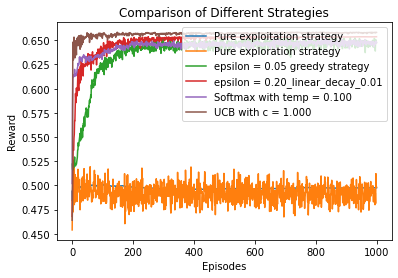

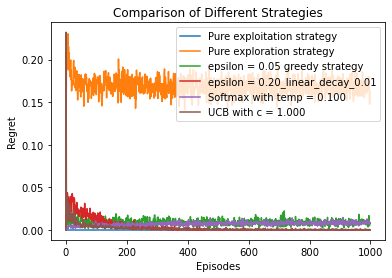

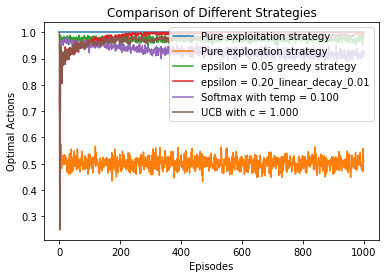

In [16]:
# =======================================================
# 2-Armed Bernoulli Bandit 
# All strategies in a single plot
# =======================================================

n_envs = 500
maxEpisodes = 1000
eps = 0.05
eps_decay = 0.20 
decay_rate = 0.01
temp = 0.1
c =1
all_strategies("BernoulliBandit", 2, eps, eps_decay, decay_rate, temp, c, n_envs, maxEpisodes)

<Figure size 1440x1080 with 0 Axes>

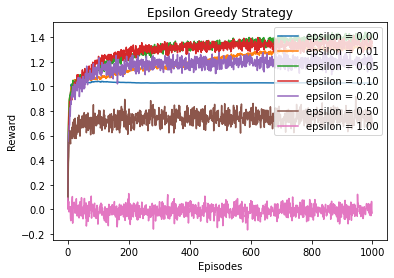

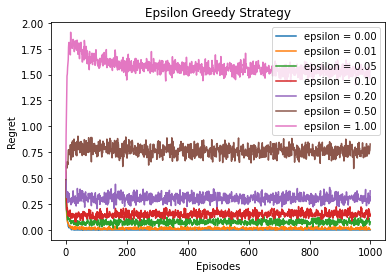

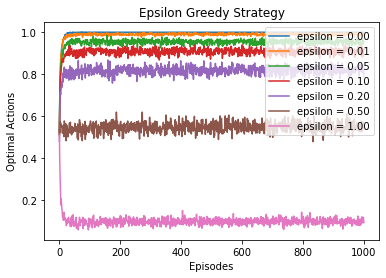

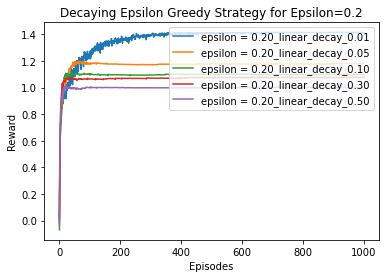

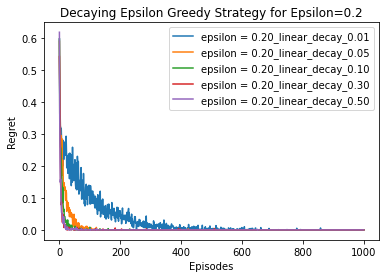

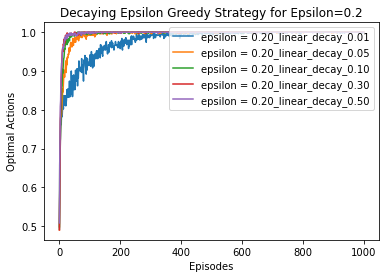

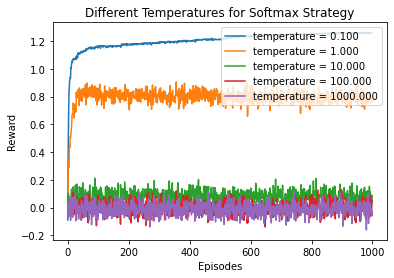

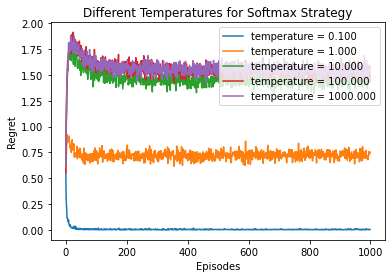

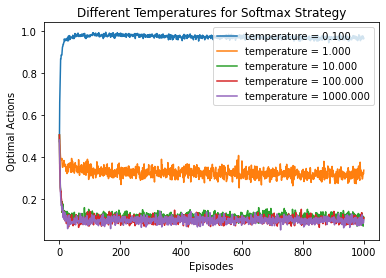

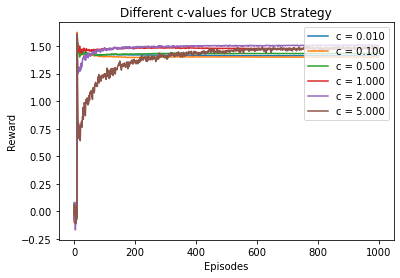

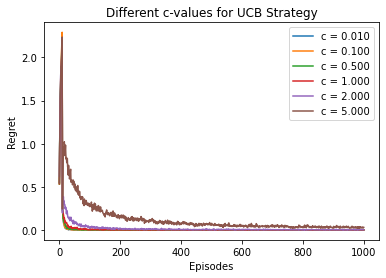

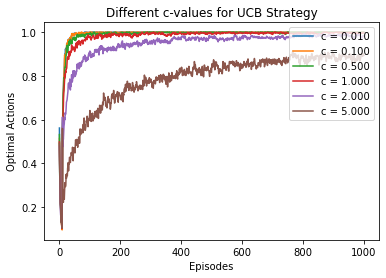

In [17]:
# =======================================================
# 10-Armed Gaussian Bandit 
# =======================================================

n_envs = 500
maxEpisodes = 1000
explore_exploit("GaussianBandit", 10, n_envs, maxEpisodes)

<Figure size 1440x1080 with 0 Axes>

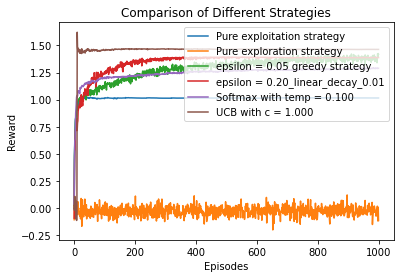

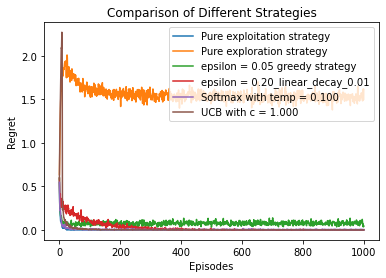

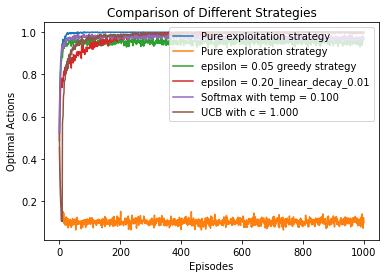

In [18]:
# =======================================================
# 10-Armed Gaussian Bandit 
# All strategies in a single plot
# =======================================================

n_envs = 500
maxEpisodes = 1000
eps = 0.05
eps_decay = 0.20 
decay_rate = 0.01
temp = 0.1
c =1
all_strategies("GaussianBandit", 10, eps, eps_decay, decay_rate, temp, c, n_envs, maxEpisodes)